In [53]:
from functions import simulador
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Função de Simulação para Obter Trace:

In [28]:
def simulate_and_get_filtered_mm1_trace(lambda_, mu_):
    # Supondo que 'simulador' seja a função que realiza a simulação
    data = simulador(lambda_, mu_, tempo_total_simulacao=10000)['trace']

    # Filtrar os eventos de saída
    filtered_served_events = data[data['Evento'] == 'Saida']

    # Criar a lista 'trace' usando
    trace = [num_clientes_na_fila for num_clientes_na_fila in filtered_served_events['Numero de clientes na fila']]

    return trace

Funções Auxiliares para Plotar Gráficos de PDF e CDF:

In [35]:
def plot_rho(samples, bins=100, cumulative=False):
    weights = np.ones_like(samples) / len(samples)

    if cumulative:
        plt.hist(samples, weights=weights, bins=bins, cumulative=True)
    else:
        plt.hist(samples, weights=weights, bins=bins)

    plt.xlabel('Valor')
    plt.ylabel('Frequência relativa')
    plt.grid(True)

Algoritmo MCMC de Inferência:

In [49]:
def calc_metropolis_hastings_acceptance_ratio(proposal, current, traceSum, traceLength):
    '''
    A fórmula da distribuição f(rho|v), como introduzida no enunciado do trabalho, resultaria na seguinte razão (a distribuição de proposta é omitida por ser simétrica):
      ((proposal**traceSum * (1 - proposal)**traceLength) * K) / ((current**traceSum * (1 - current)**traceLength) * K)
    A constante K estará presente tanto no numerador quando denominador, podendo ser eliminada:
      (proposal**traceSum * (1 - proposal)**traceLength) / (current**traceSum * (1 - current)**traceLength)
    A expressão acima, conteria no numerador e denominador números extremamente pequenos devido aos expoentes presentes.
    Desse modo, aplicamos a função exponencial e logaritmica sequencialmente para evitar divisões por zero e números infinitos causados por erros de precisão:
    '''
    log_numer = traceSum * np.log(proposal) + traceLength * np.log(1 - proposal)
    log_denom = traceSum * np.log(current) + traceLength * np.log(1 - current)
    log_ratio = log_numer - log_denom
    
    if log_ratio >= 0:
        return 1
    else:
        return np.exp(log_ratio)

def mcmc_sample_rho_given_trace(traceSum, traceLength, initialRho=0.5, iterations=100000, burnIn=1000):

    currentRho = initialRho
    totalAccepted = 0
    totalRejected = 0

    # METROPOLIS-HASTINGS
    doneWithBurnIn = False
    for i in range(iterations):
        if i >= burnIn and not doneWithBurnIn:
            samples = [currentRho]
            doneWithBurnIn = True
        proposalRho = np.random.uniform(0, 1)
        acceptanceRatio = calc_metropolis_hastings_acceptance_ratio(proposalRho, currentRho, traceSum, traceLength)
        if acceptanceRatio >= 1 or acceptanceRatio > np.random.uniform(0, 1):
            currentRho = proposalRho
            if doneWithBurnIn:
                samples.append(proposalRho)
                totalAccepted += 1
        elif doneWithBurnIn:
            samples.append(currentRho)
            totalRejected += 1
    

    print('Valor médio de Rho a partir do MCMC: ', np.mean(samples))
    print('Variância: ', np.var(samples))
    
    return samples

Executando

In [50]:
trace = simulate_and_get_filtered_mm1_trace(lambda_=7, mu_=10)
samples = mcmc_sample_rho_given_trace(traceSum=sum(trace), traceLength=len(trace), iterations=1000000, initialRho=0.5, burnIn=1000)
print('m = ', len(trace))
print('y = ', sum(trace))

Valor médio de Rho a partir do MCMC:  0.6977528172950368
Variância:  9.731681776522295e-07
m =  69671
y =  160824


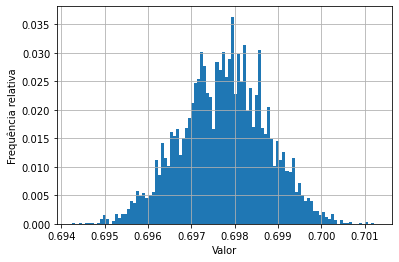

In [51]:
plot_rho(samples, bins=100)

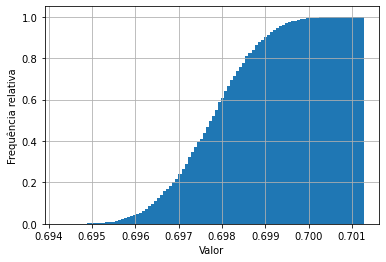

In [52]:
plot_rho(samples, bins=100, cumulative=True)

Validação de Corretude (demora para rodar):

In [54]:
def get_confidence_interval(samples, confidence_rate=0.95):
    x = np.mean(samples)
    n = len(samples)
    s = np.std(samples)
    z = norm.ppf((1 + confidence_rate) / 2)  # Valor crítico do intervalo de confiança

    lower_bound = x - z * (s / np.sqrt(n))
    upper_bound = x + z * (s / np.sqrt(n))

    return (lower_bound, upper_bound)

In [55]:
def simulate_traces_and_estimate_rho(lamda, mu, number_of_traces=10000):
    estimates = [np.mean(mcmc_sample_rho_given_trace(sum(simulate_and_get_filtered_mm1_trace(lamda, mu)), len(trace))) for _ in range(number_of_traces)]

    real_rho = lamda / mu
    average_rho = np.mean(estimates)
    confidence_interval = get_confidence_interval(estimates)

    print(f'Real Rho: {real_rho}')
    print(f'Average of Estimated Rhos: {average_rho}')
    print(f'Confidence Interval: {confidence_interval}')

    return estimates


## 6.2 Casos Especiais

### a) $m=100, y=\sum v_i = 25$

In [57]:
m = 100
v = 25
samples = mcmc_sample_rho_given_trace(traceSum=m, traceLength=v, iterations=1000000, initialRho=0.5, burnIn=1000)
print('m = ', m)
print('y = ', v)

Valor médio de Rho a partir do MCMC:  0.7955272269558225
Variância:  0.0012661977763090682
m =  100
y =  25


### b) $m=100, y=\sum v_i = 100$

In [58]:
m = 100
v = 100
samples = mcmc_sample_rho_given_trace(traceSum=m, traceLength=v, iterations=1000000, initialRho=0.5, burnIn=1000)
print('m = ', m)
print('y = ', v)

Valor médio de Rho a partir do MCMC:  0.5001344311919568
Variância:  0.0012361544334565343
m =  100
y =  100


### c)

### d) 